Importing relevant packages and modules

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
import sys
from pathlib import Path
import torch
import numpy as np
import tqdm

# Plotting
import matplotlib
from matplotlib import pyplot as plt
plt.style.use('bioAI.mplstyle')

'''
CUSTOM PACKAGES
'''
# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None

from Models import SorscherRNN
from Experiment import Experiment
from datahandling import Dataset, MESampler
from plotting_functions import *
from synthetic_grid_cells import *
from methods import *
from stats import *

In [3]:
#base_path = Path("/storA/GridCells/")
base_path = "/mnt/WD12TB-HDD"
experiment = Experiment(name="gg-3ME", base_path=base_path)
experiment.setup()
boxsize = experiment.environments[0].boxsize

Experiment <gg-3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


In [4]:
module_indices = np.load(f"{experiment.paths['experiment']}/module_indices_new.npz")
print(module_indices.files)
module_indices = module_indices['C0_from_env_2']

ncells = len(module_indices)
ncells

['C0_from_env_2']


375

In [5]:
gc_scores = []
score_filenames = os.listdir(experiment.paths["grid_scores"])
for fname in score_filenames:
    if not "novel" in fname:
        with open(experiment.paths["grid_scores"] / f"{fname}", "rb") as f:
            gc_scores.append(pickle.load(f))
gc_scores = np.array(gc_scores)

In [6]:
# sort by sum of scores
gcs_sorted = np.argsort(gc_scores.sum(axis=0))[::-1]
# show overlap between torus and grid cells
len(set(module_indices) & set(gcs_sorted[:ncells]))

104

In [7]:
len((set(gcs_sorted) - set(module_indices)))

3721

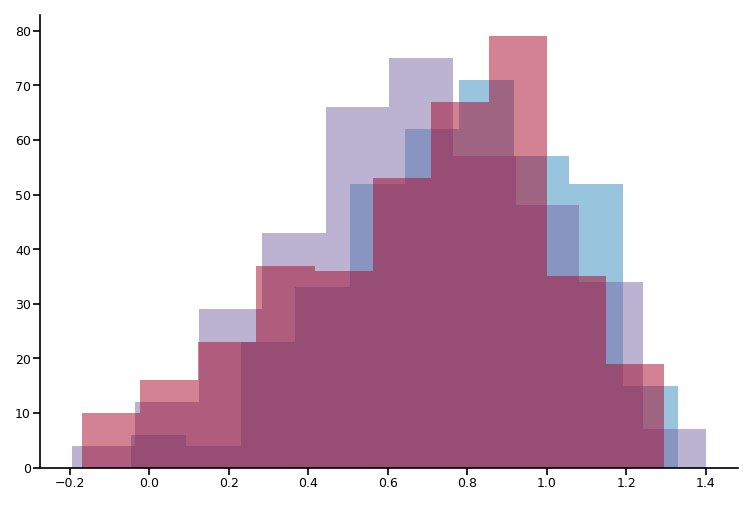

In [8]:
for env_i in range(3):
    plt.hist(gc_scores[env_i, gcs_sorted[:ncells]],alpha=0.5, label=f"env {env_i}")

(array([93., 76., 57., 61., 28., 25., 19., 11.,  0.,  5.]),
 array([1.57849525, 1.7803784 , 1.98226155, 2.1841447 , 2.38602785,
        2.587911  , 2.78979415, 2.9916773 , 3.19356045, 3.3954436 ,
        3.59732675]),
 <BarContainer object of 10 artists>)

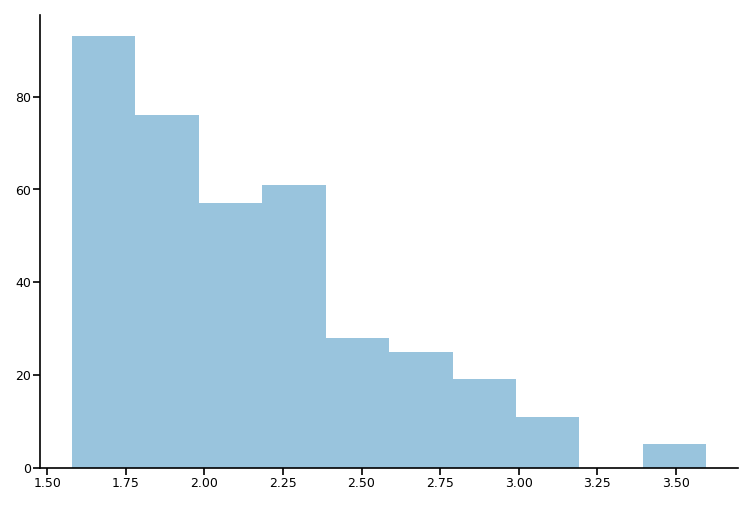

In [9]:
plt.hist(gc_scores.sum(axis=0)[gcs_sorted[:ncells]],alpha=0.5, label=f"sum")

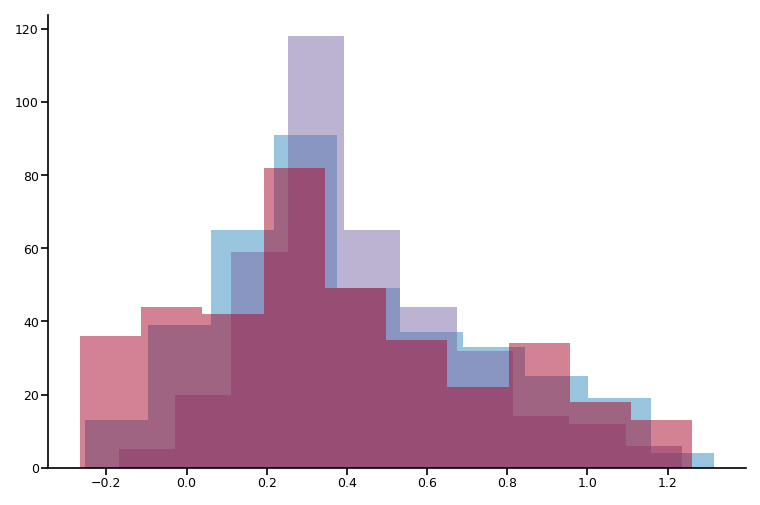

In [10]:
for env_i in range(3):
    plt.hist(gc_scores[env_i, module_indices],alpha=0.5, label=f"env {env_i}")

In [11]:
def load_model(experiment, random_model=False):
    # load weights
    checkpoint_filenames = filenames(experiment.paths['checkpoints'])
    # load model latest (wrt. #epochs trained)
    print(f"Loading model at epoch = {checkpoint_filenames[-1]}", experiment.paths['checkpoints'] / checkpoint_filenames[-1])
    checkpoint = torch.load(experiment.paths['checkpoints'] / checkpoint_filenames[-1])
    # instantiate trained model this time
    model = SorscherRNN(experiment.pc_ensembles, Ng=experiment.params['Ng'], Np=experiment.params['Np'])
    if not random_model:
        model.load_state_dict(checkpoint['model_state_dict'])
    return model

model = load_model(experiment)
random_model = load_model(experiment, random_model=True)

Loading model at epoch = 02999 /mnt/WD12TB-HDD/data/emergent-grid-cells/gg-3ME/checkpoints/02999
Loading model at epoch = 02999 /mnt/WD12TB-HDD/data/emergent-grid-cells/gg-3ME/checkpoints/02999


In [12]:
# detach experiment specifics
params = experiment.params
environments = experiment.environments
agents = experiment.agents
pc_ensembles = experiment.pc_ensembles
paths = experiment.paths

num_workers = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device=}")

# Initialise data loading
num_samples = params['nsteps'] * params['batch_size'] # * params['nepochs']
dataset = Dataset(agents = agents, pc_ensembles = pc_ensembles, num_samples = num_samples, seq_len=20)#, **params)
datasampler = eval(params['sampler'])(num_environments = len(environments), num_samples = num_samples, \
                                      num_epochs = params['nepochs'])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'], sampler = datasampler, num_workers=num_workers)

device=device(type='cuda')


In [13]:
def pred_inference(model, inputs, labels, positions, indices, trajectory_slice=None):
    trajectory_slice = slice(0,positions.shape[1]) if trajectory_slice is None else trajectory_slice
    position_slice = slice(trajectory_slice.start,trajectory_slice.stop+1)
    indices = np.array(indices)
    log_predictions = model(inputs, log_softmax=True)
    #loss = self.loss_fn(log_predictions, labels, weight_decay)
    #labels = labels.to(self.device, dtype=self.dtype)
    positions = positions.to(model.device, dtype=model.dtype)
    pred_error = model.position_error(log_predictions[:,trajectory_slice], 
                                      positions[:,position_slice], indices, model.place_cell_ensembles)
    return pred_error.item()

In [14]:
def prune_model(model, dataloader, module_indices, sorted_gs_idxs, nsteps=40, trajectory_slice=slice(19,20)):
    pe_true = []
    pe_random = []
    pe_gcs = []
    pe_exclusive_gcs = []
    pe_random_torus = []
    pe_random_model = []

    # bag/hat to keep continuous pruning idxs in
    random_idxs2prune = np.array([])
    random_torus_idxs2prune = np.array([])
    random_gcs_idxs2prune = np.array([])
    random_exclusive_gcs_idxs2prune = np.array([])

    top_gcs_idxs = list(sorted_gs_idxs[:len(module_indices)])
    # get list of exclusive grid cell indices not in module_indices
    exclusive_gcs_idxs = list(set(top_gcs_idxs) - set(module_indices))

    i = 0
    for inputs, labels, positions, indices in dataloader:
        if i == nsteps:
            break

        # get number of cells to prune
        if (len(module_indices) % nsteps) > i:
            ncells2prune = int(len(module_indices)  / nsteps) + 1
        else:
            ncells2prune = int(len(module_indices)  / nsteps)

        # true
        model.prune_mask = []
        pe_true.append(pred_inference(model, inputs, labels, positions, indices, trajectory_slice))

        # random
        remaining = list(set(range(model.Ng)) - set(random_idxs2prune))
        tmp = np.random.choice(remaining, size=ncells2prune, replace=False)
        random_idxs2prune = np.append(random_idxs2prune, tmp).astype(int)
        model.prune_mask = random_idxs2prune
        pe_random.append(pred_inference(model, inputs, labels, positions, indices, trajectory_slice))

        # random gcs
        remaining = list(set(top_gcs_idxs) - set(random_gcs_idxs2prune))
        tmp = np.random.choice(remaining, size=ncells2prune if len(remaining) > ncells2prune else len(remaining), replace=False)
        random_gcs_idxs2prune = np.append(random_gcs_idxs2prune, tmp).astype(int)
        model.prune_mask = random_gcs_idxs2prune
        pe_gcs.append(pred_inference(model, inputs, labels, positions, indices, trajectory_slice))

        # random exclusive gcs
        remaining = list(set(exclusive_gcs_idxs) - set(random_exclusive_gcs_idxs2prune))
        tmp = np.random.choice(remaining, size=ncells2prune if len(remaining) > ncells2prune else len(remaining), replace=False)
        random_exclusive_gcs_idxs2prune = np.append(random_exclusive_gcs_idxs2prune, tmp).astype(int)
        model.prune_mask = random_exclusive_gcs_idxs2prune
        pe_exclusive_gcs.append(pred_inference(model, inputs, labels, positions, indices, trajectory_slice))

        # random torus
        remaining = list(set(module_indices) - set(random_torus_idxs2prune))
        tmp = np.random.choice(remaining, size=ncells2prune if len(remaining) > ncells2prune else len(remaining), replace=False)
        random_torus_idxs2prune = np.append(random_torus_idxs2prune, tmp).astype(int)
        model.prune_mask = random_torus_idxs2prune
        pe_random_torus.append(pred_inference(model, inputs, labels, positions, indices, trajectory_slice))

        # random model
        pe_random_model.append(pred_inference(random_model, inputs, labels, positions, indices, trajectory_slice))
        
        i+=1
            
    return pe_true, pe_random, pe_gcs, pe_exclusive_gcs, pe_random_torus, pe_random_model

In [15]:
def prune_stats(nstats, *args, **kwargs):
    stats = []
    for j in tqdm.trange(nstats):
        stats.append(np.array(prune_model(*args, **kwargs)))
    return np.array(stats) # shape: (nstats x 6 x nsteps)

In [16]:
nsteps = 60
nstats = 30
load_stats = False

if load_stats:
    with open(experiment.paths['experiment'] / "pruning_errors_new.pkl", "rb") as f:
        pruning_errors = pickle.load(f)
else:
    pruning_errors = prune_stats(nstats, model, dataloader, module_indices, gcs_sorted, nsteps=nsteps)
    # save pruning errors statistics - since it takes so long to compute it can be loaded instead
    with open(experiment.paths['experiment'] / "pruning_errors_new.pkl", "wb") as f:
        pickle.dump(pruning_errors, f)

100%|██████████| 30/30 [1:30:27<00:00, 180.92s/it]


In [17]:
panesize = set_size(width=345, mode='tall')
panesize

figsize=(panesize[0],panesize[1]*2/6)
figsize=np.array(figsize)

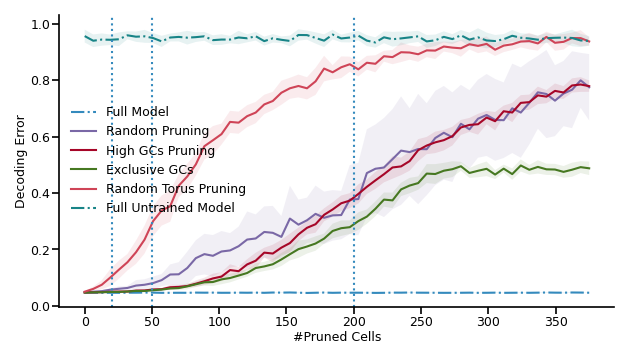

In [19]:
fig, ax = plt.subplots(figsize=figsize)
x_ticks = np.linspace(0, ncells, nsteps)
labels = ['Full Model', 'Random Pruning', 'High GCs Pruning', 'Exclusive GCs', 'Random Torus Pruning', 'Full Untrained Model']
ls = ['-']*len(labels)
ls[0] = '-.'
ls[-1] = '-.'

mean_error = np.mean(pruning_errors,axis=0)
std_error = np.std(pruning_errors,axis=0)
median_error = np.median(pruning_errors,axis=0)
mad_error = mad(pruning_errors,axis=0)
for i in range(len(labels)): # set order to change color according to color-cycler
    #ax.plot(x_ticks, mean_error[i], label=labels[i])#np.mean(pruning_i,axis=0))
    #ax.fill_between(x_ticks, mean_error[i] + std_error[i], mean_error[i] - std_error[i], alpha=0.1)
    ax.plot(x_ticks, median_error[i], label=labels[i], ls=ls[i])#np.mean(pruning_i,axis=0))
    ax.fill_between(x_ticks, median_error[i] + mad_error[i], median_error[i] - mad_error[i], alpha=0.1)

ax.legend()
ax.set_xlabel('#Pruned Cells')
ax.set_ylabel('Decoding Error')

ax.axvline(20, ls=':')
ax.axvline(50, ls=':')
ax.axvline(200, ls=':')

#fig.savefig("/home/vemundss/Desktop/prune")
#fig.savefig(experiment.paths['experiment'] / f'plots/pruning')
fig.savefig(experiment.paths['experiment'] / f'plots/pruning_new')


### Investigate pruning distribution

/tmp/ipykernel_514631/2549402989.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots()


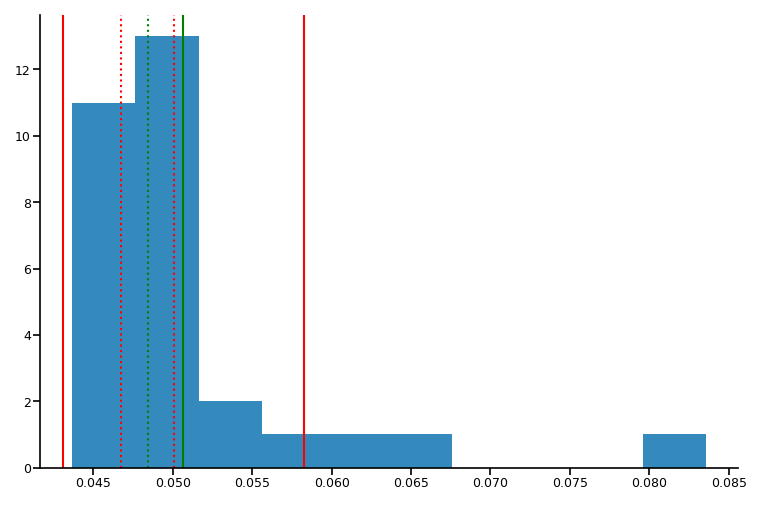

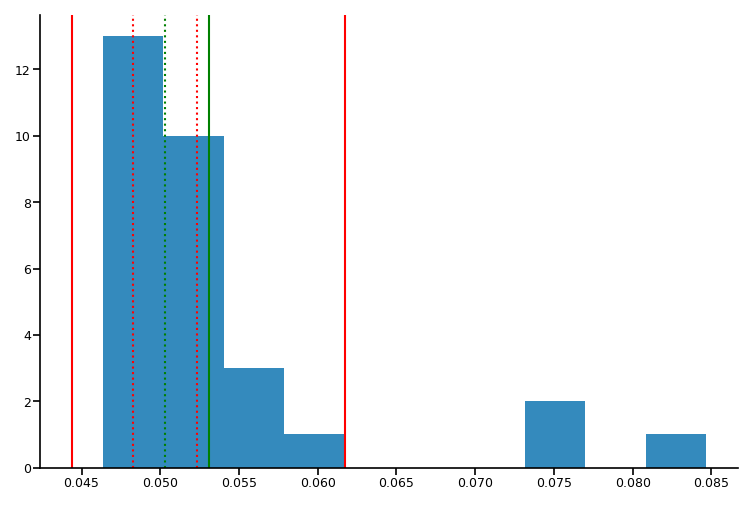

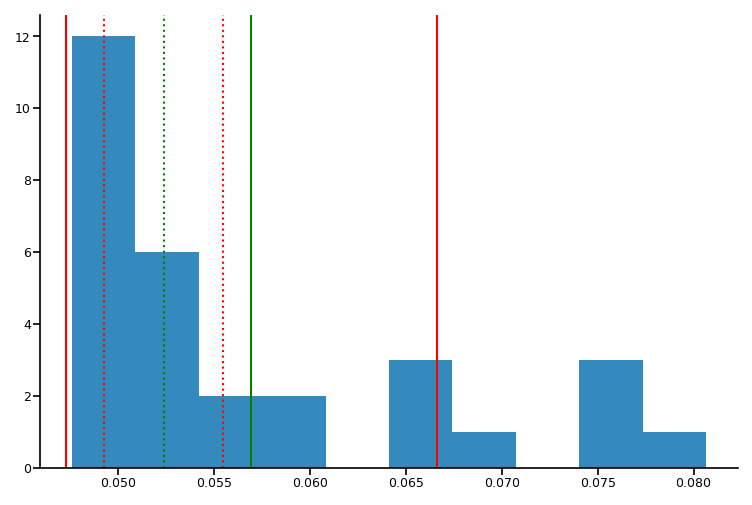

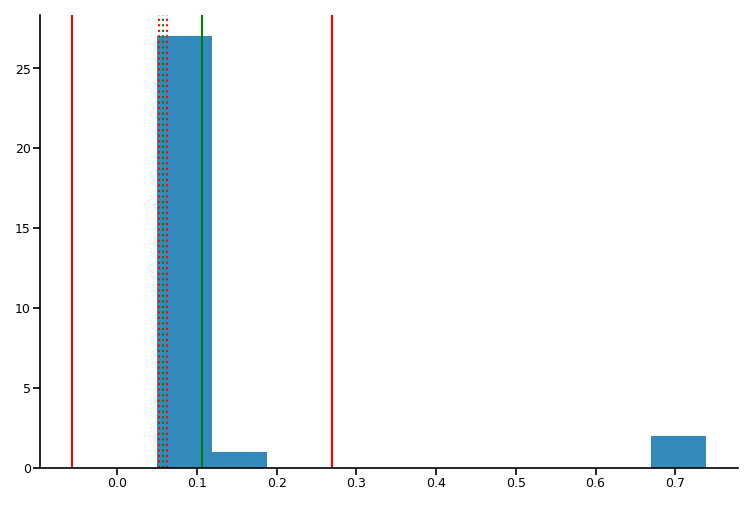

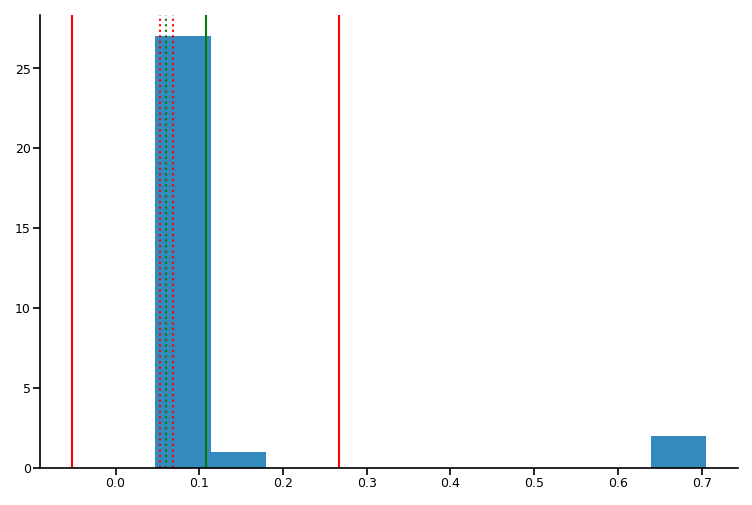

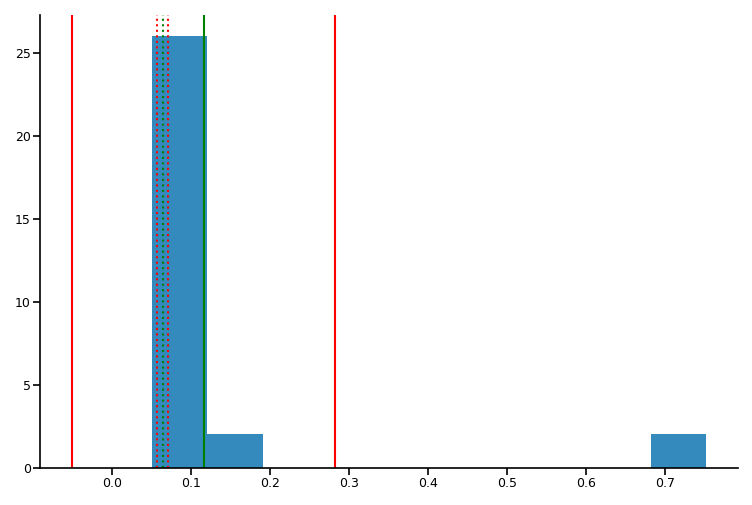

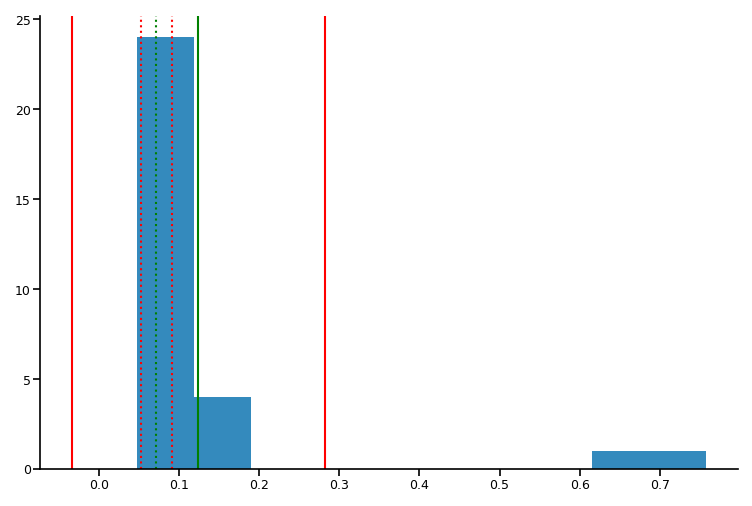

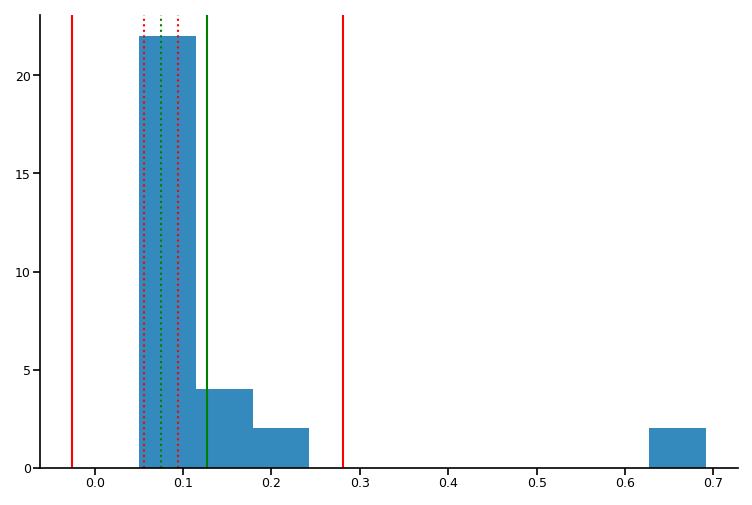

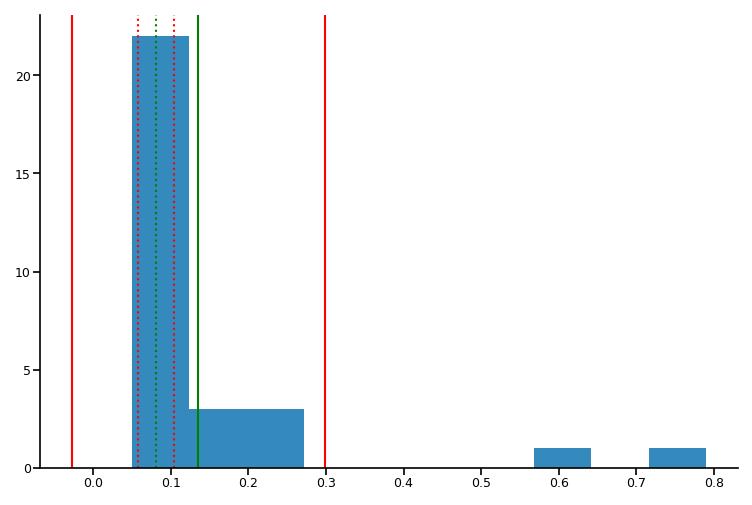

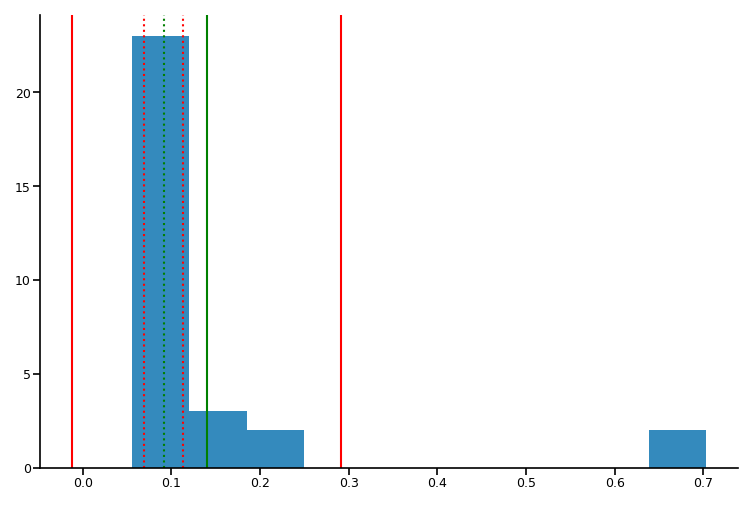

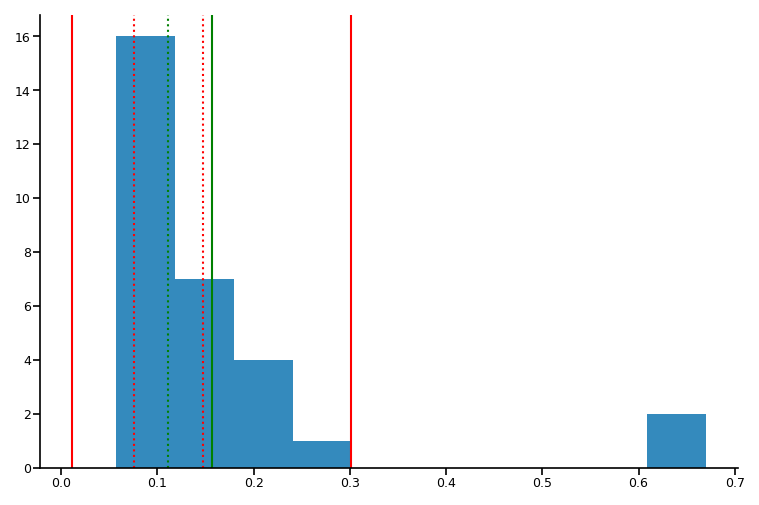

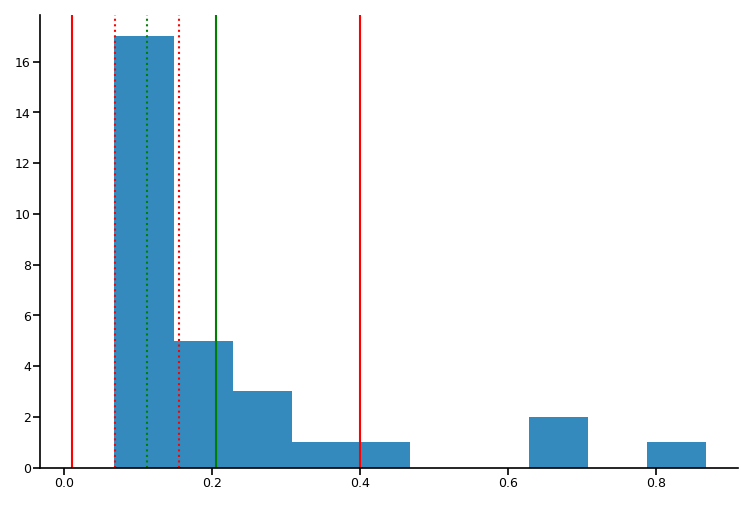

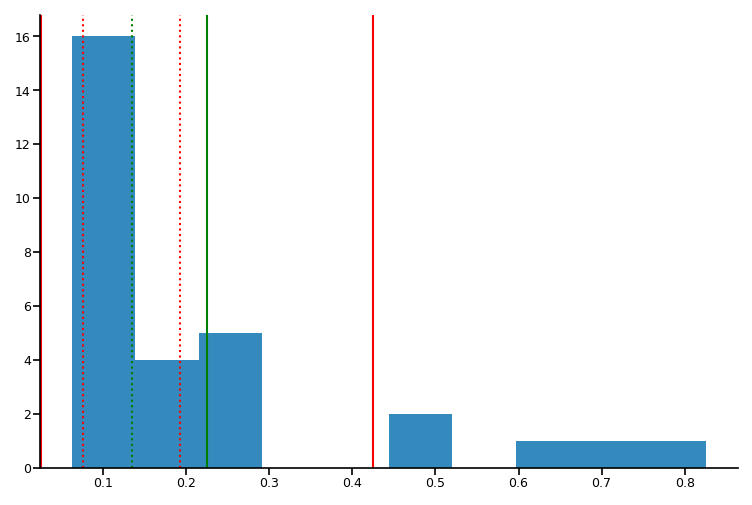

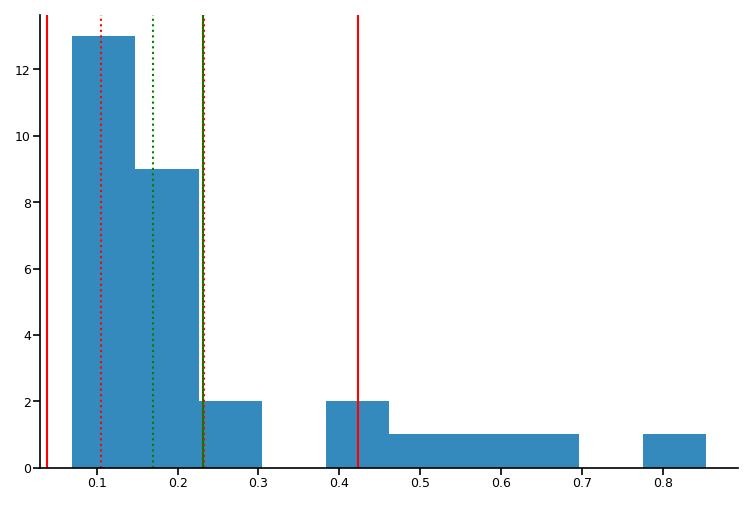

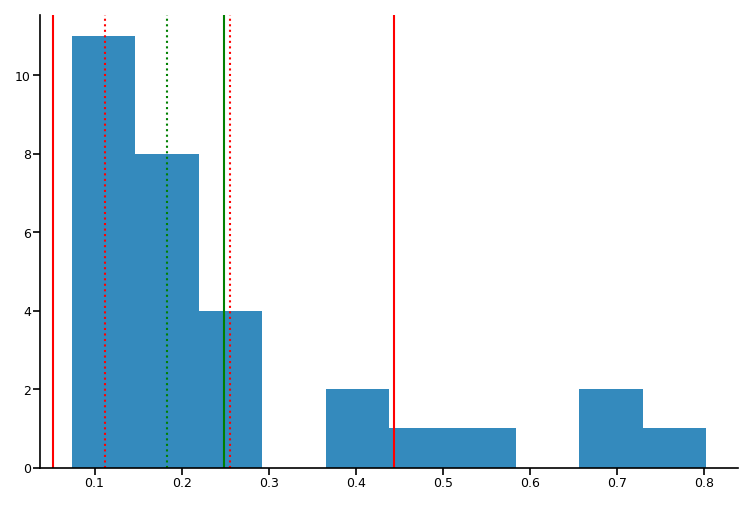

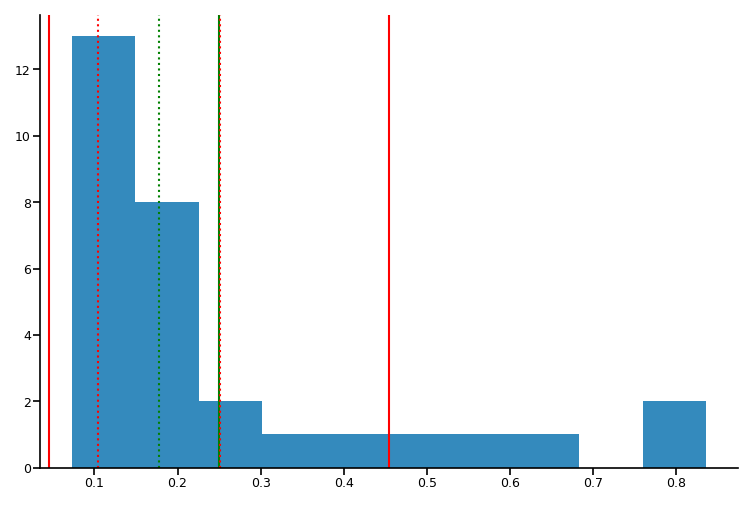

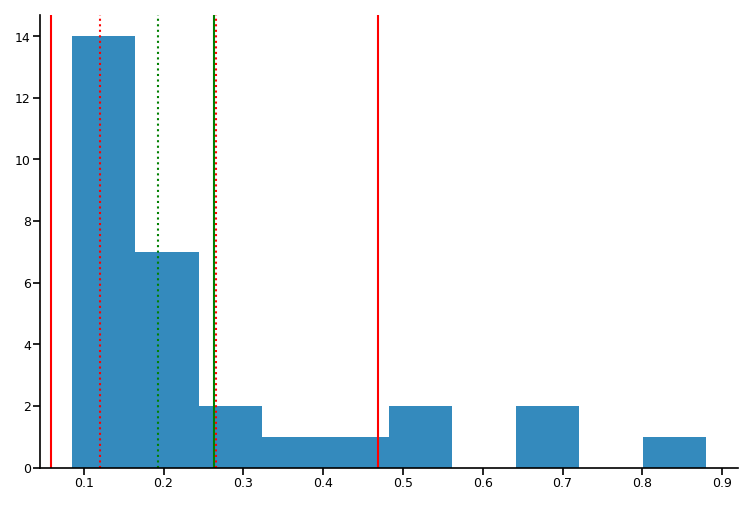

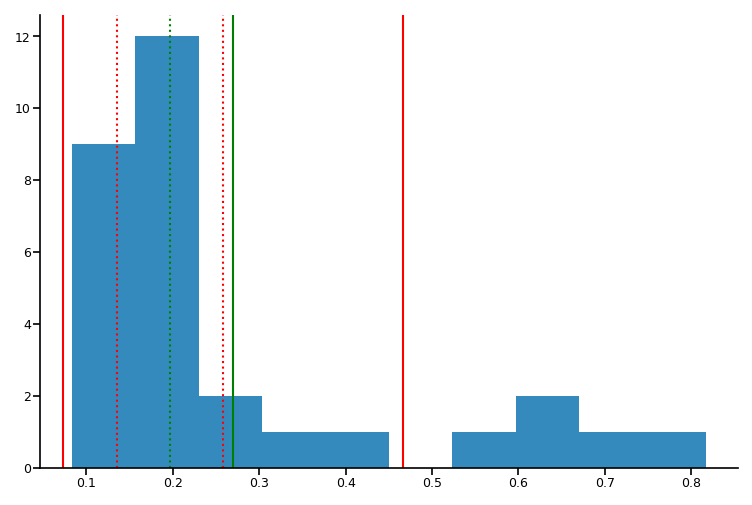

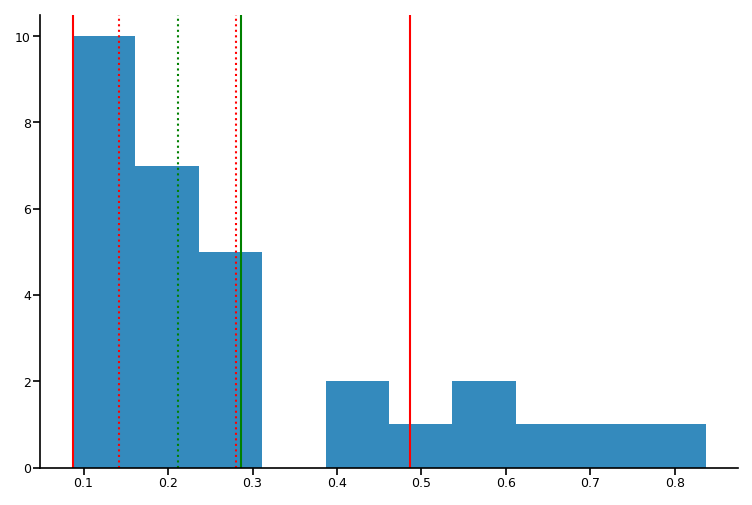

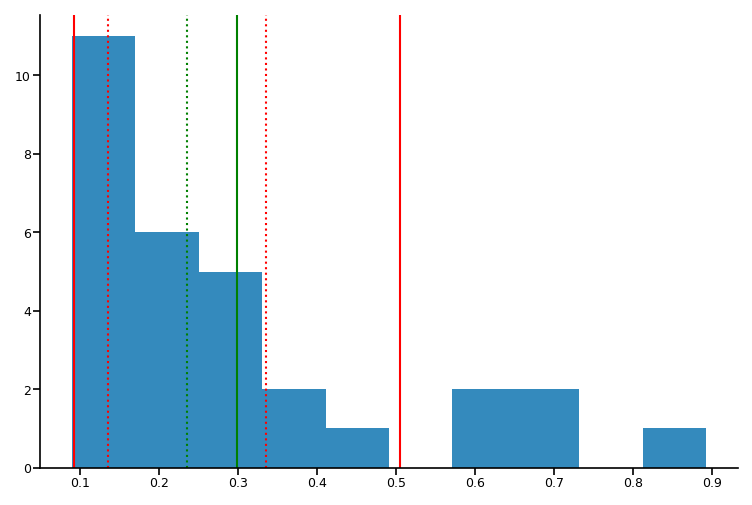

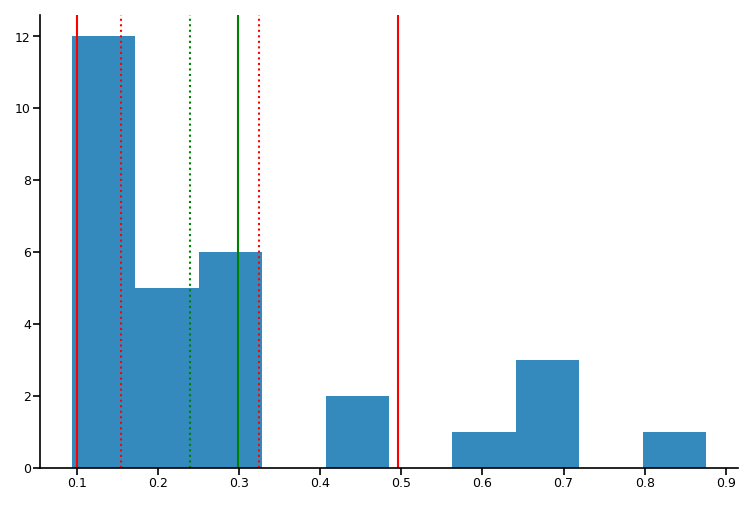

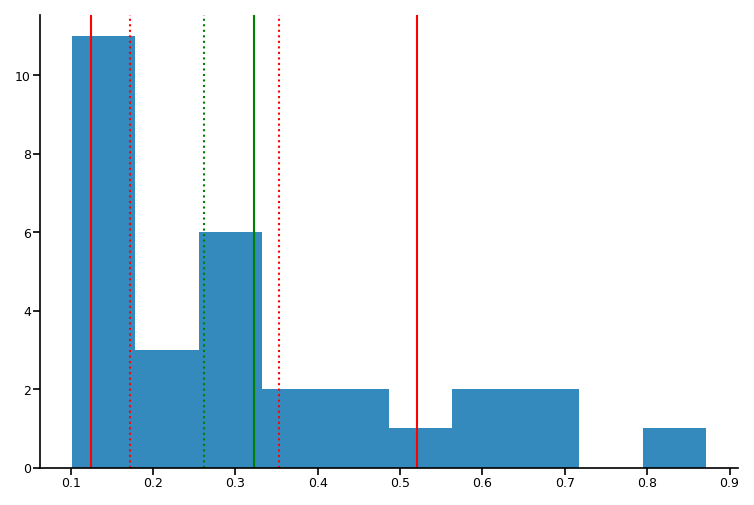

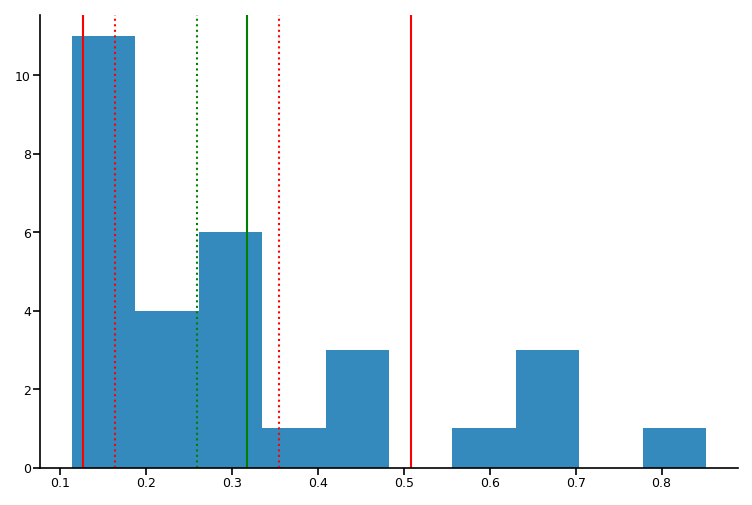

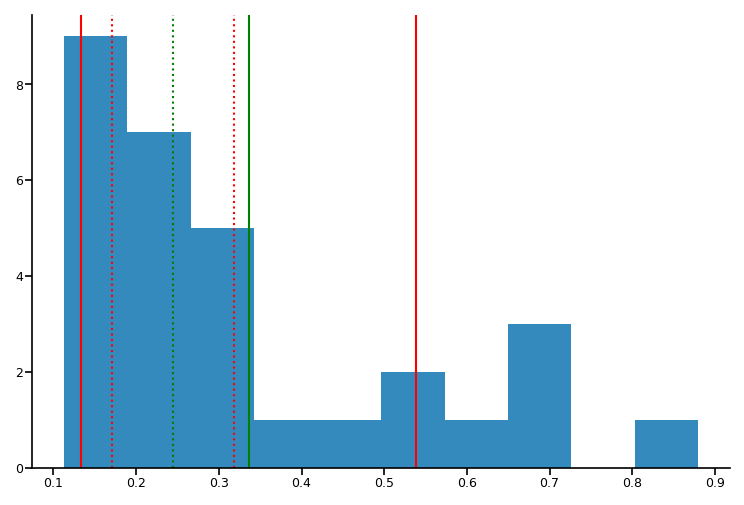

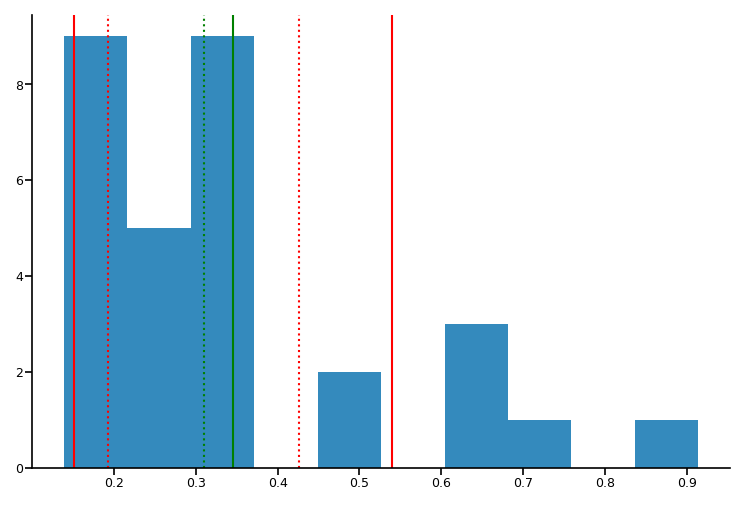

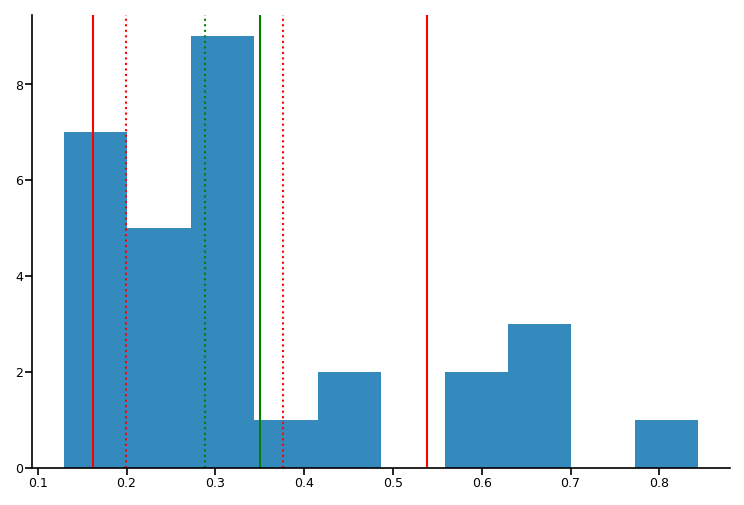

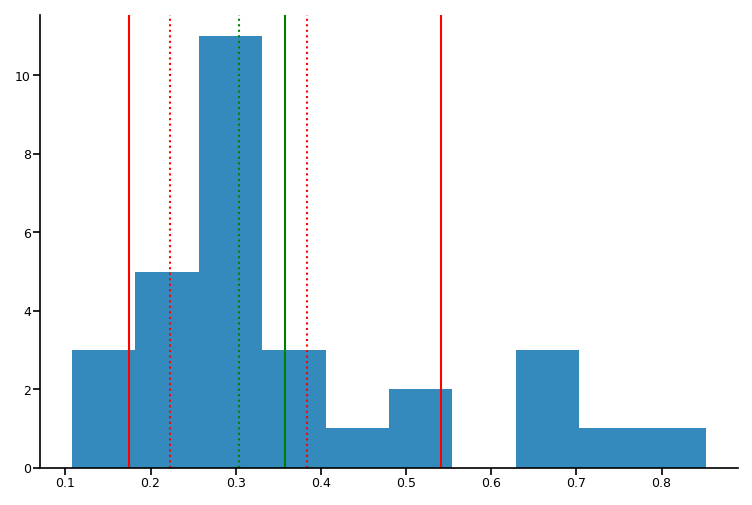

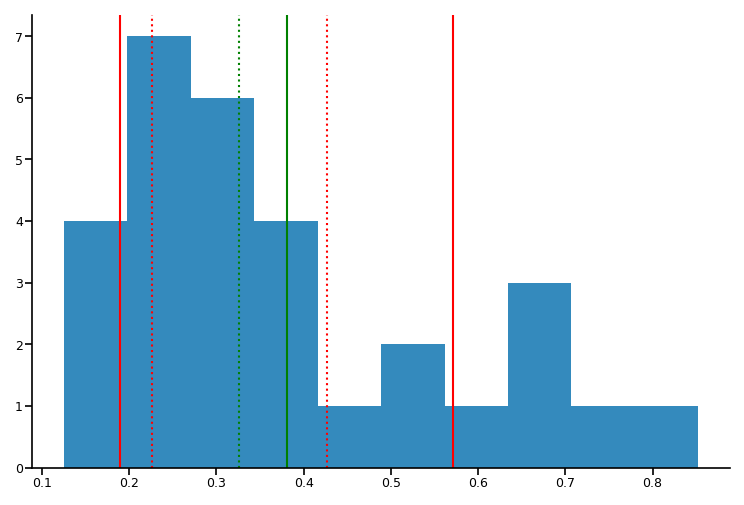

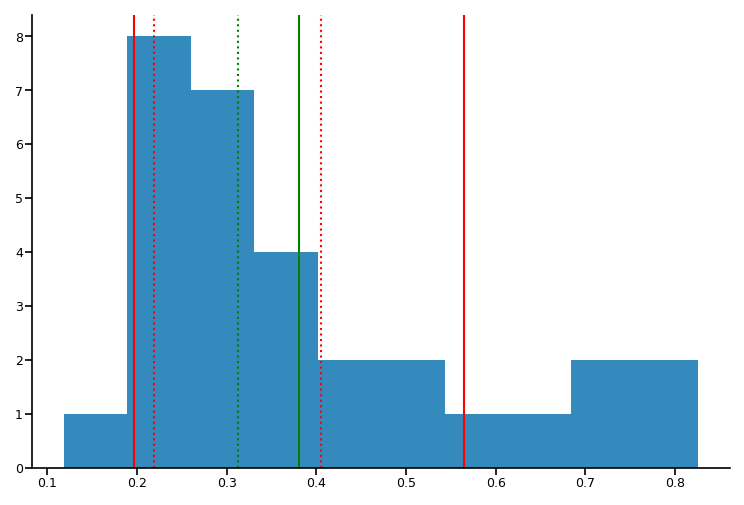

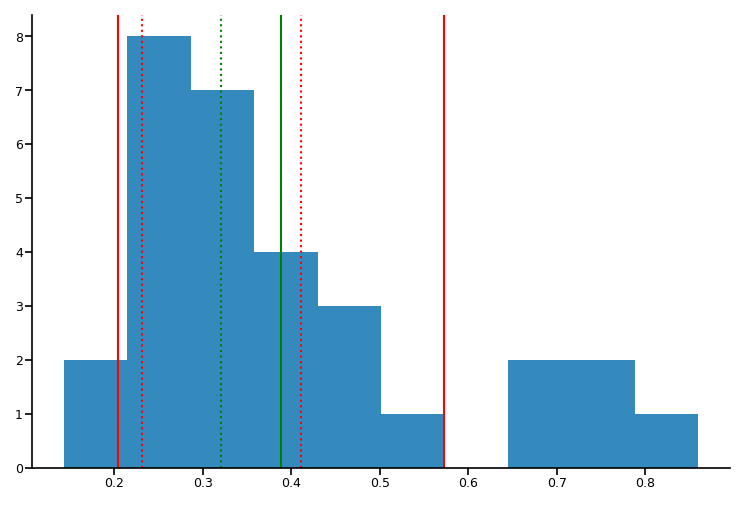

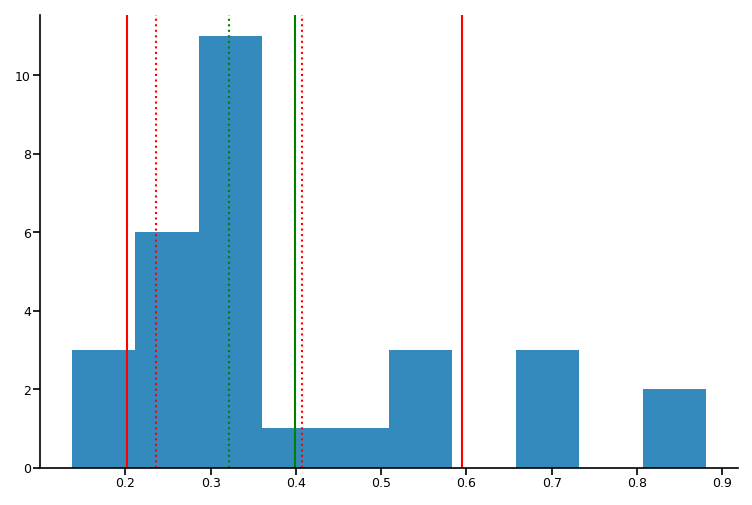

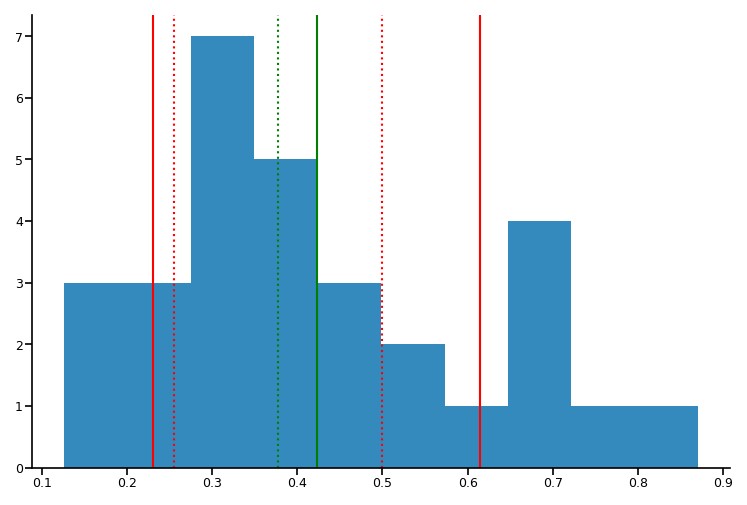

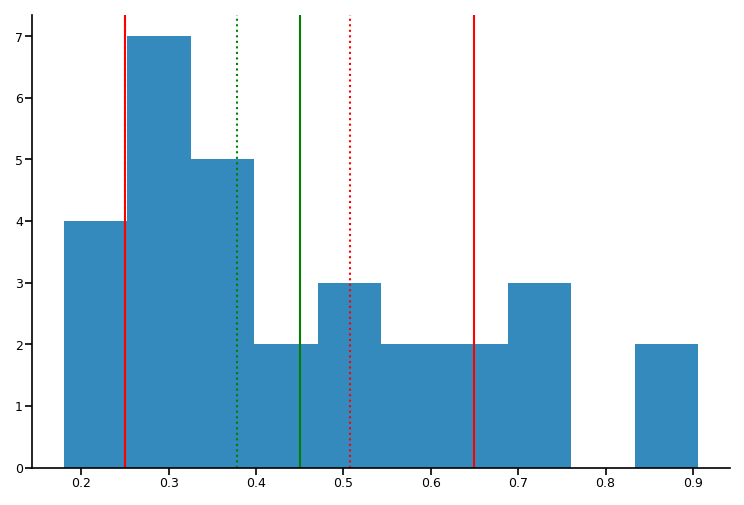

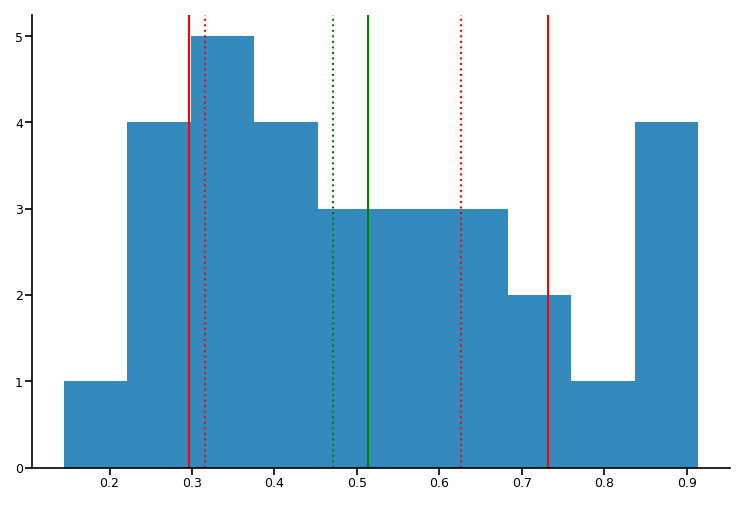

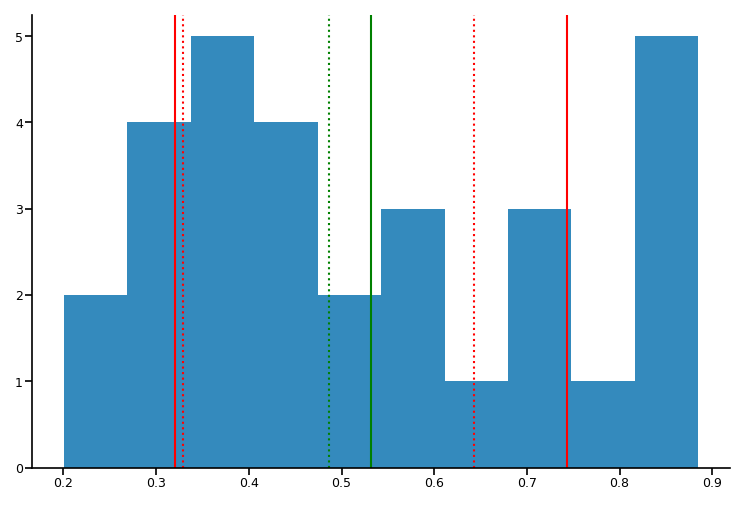

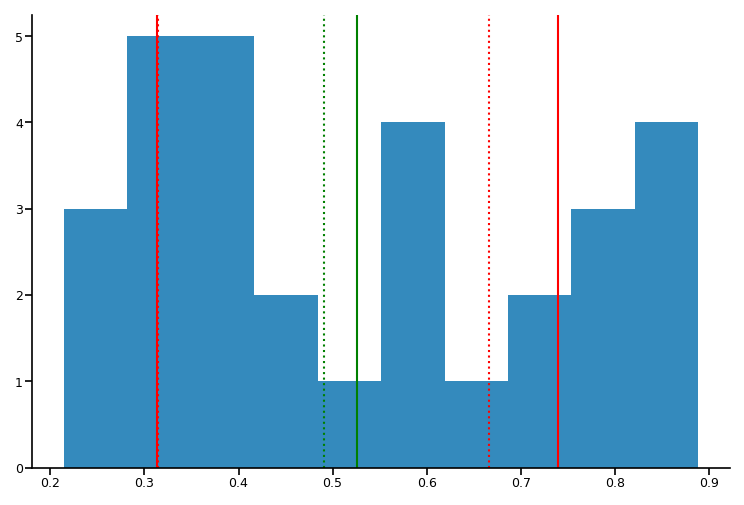

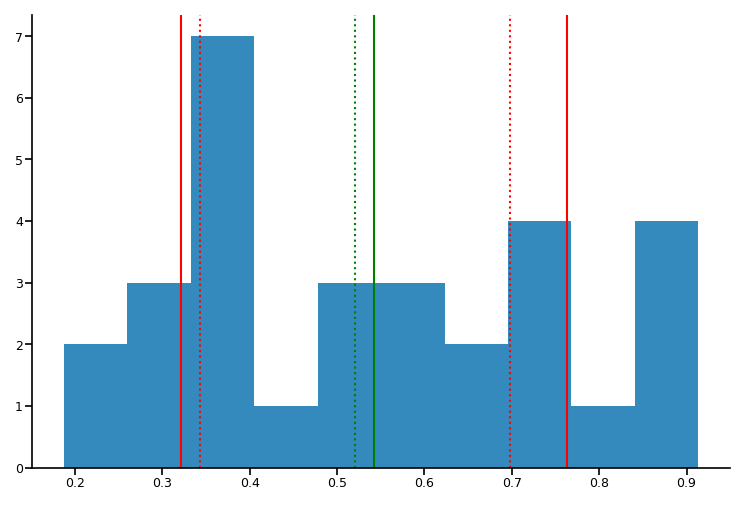

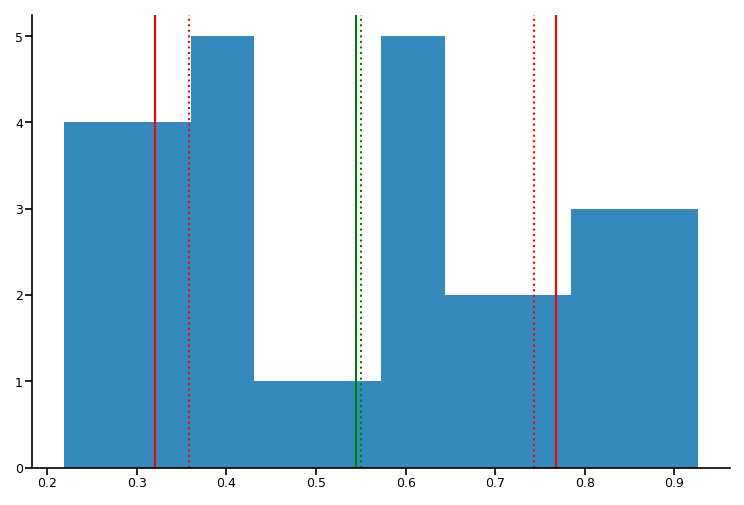

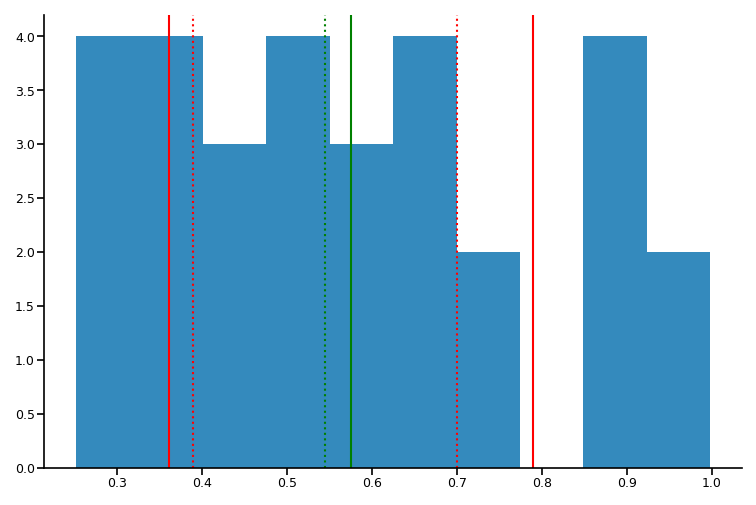

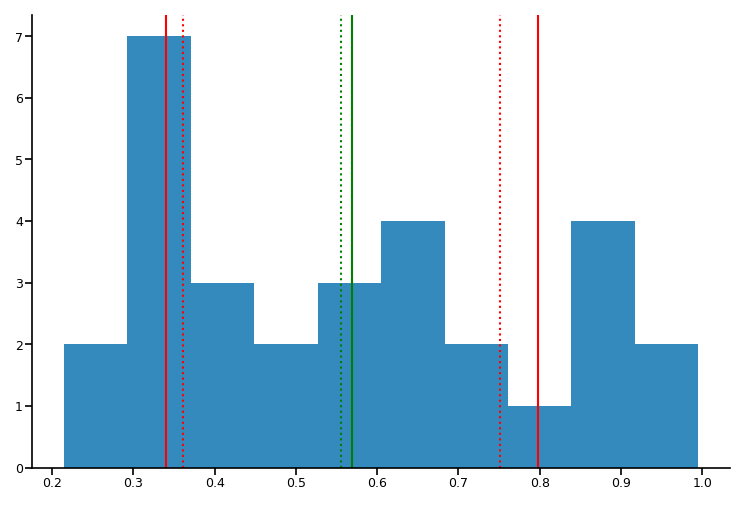

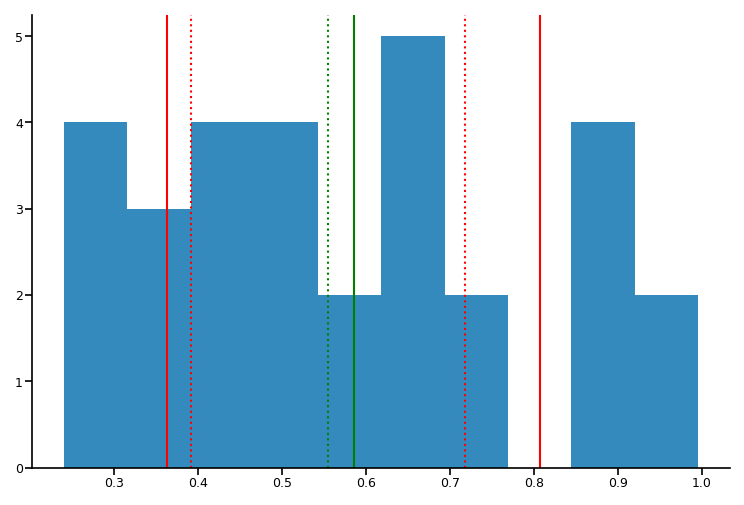

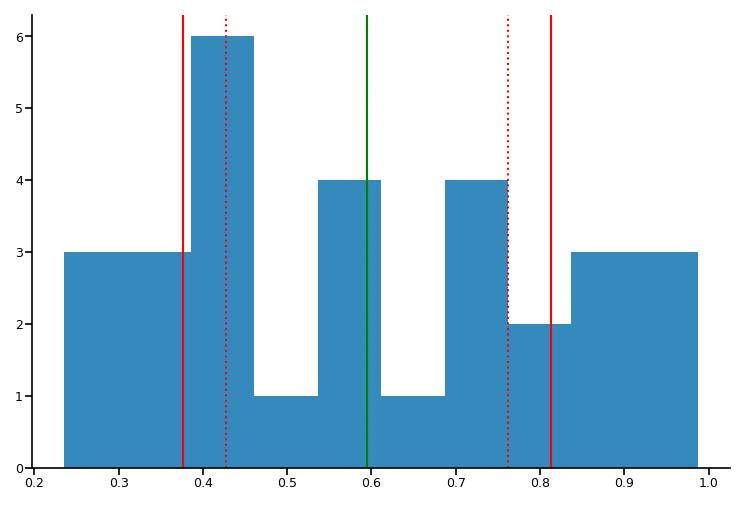

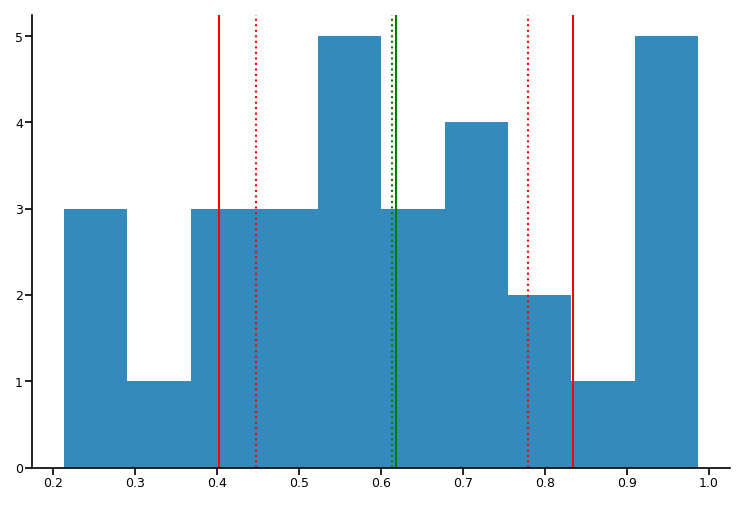

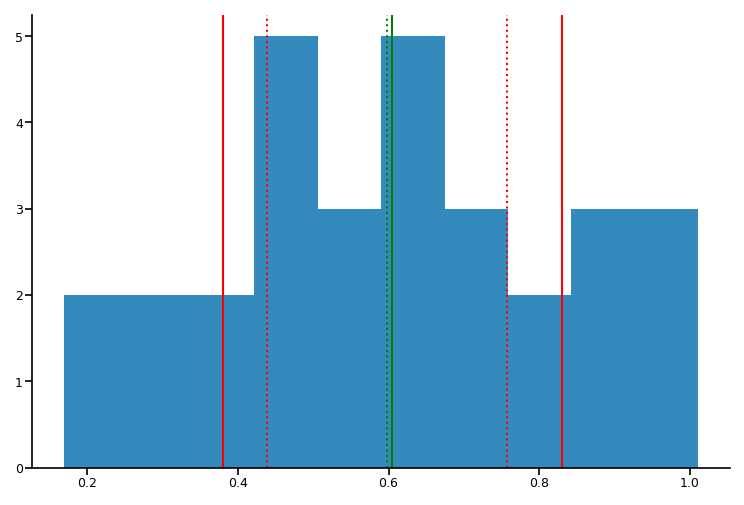

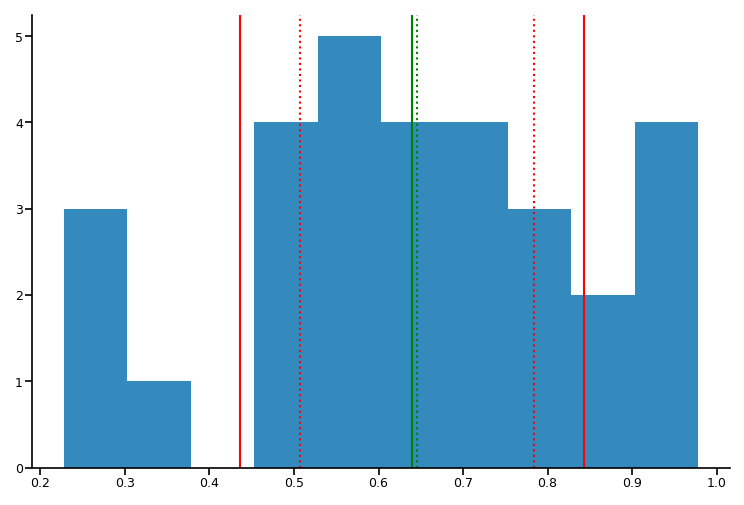

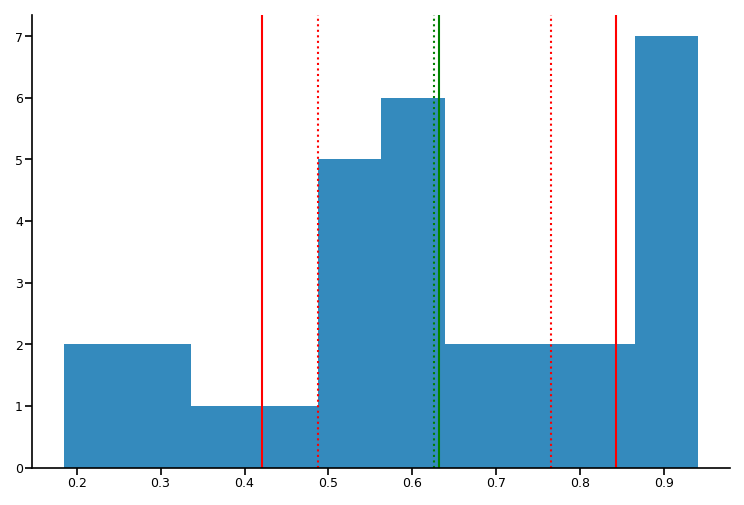

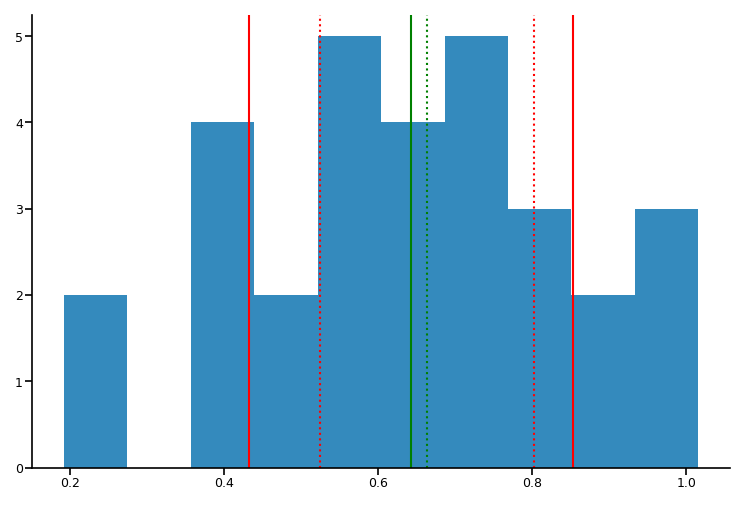

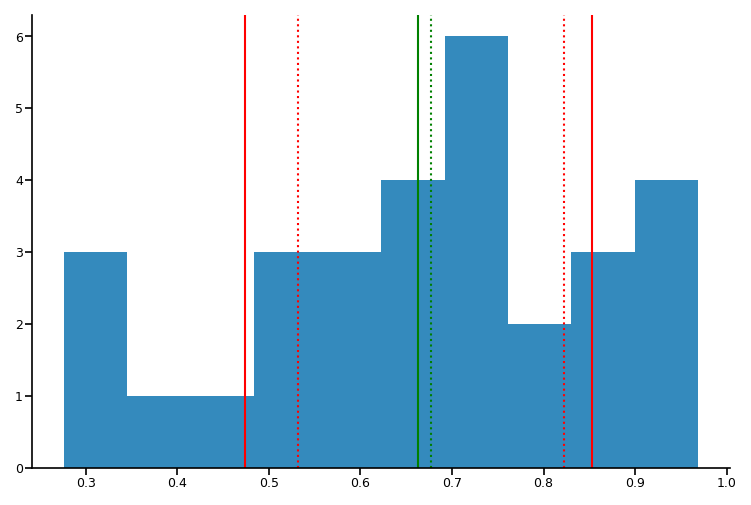

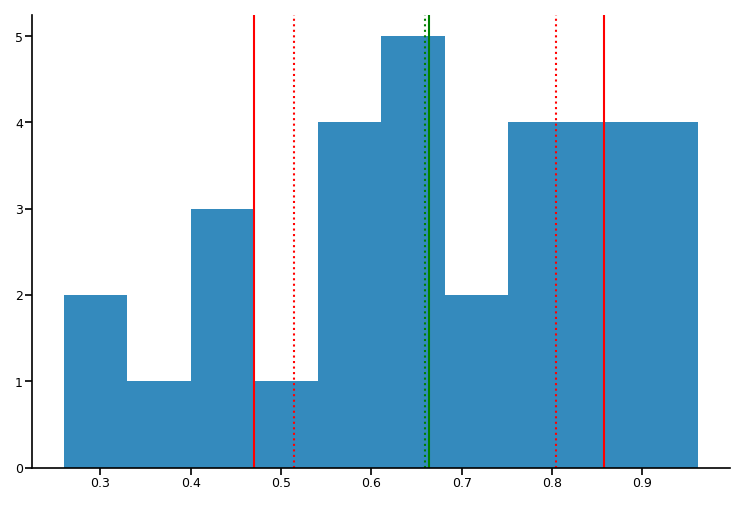

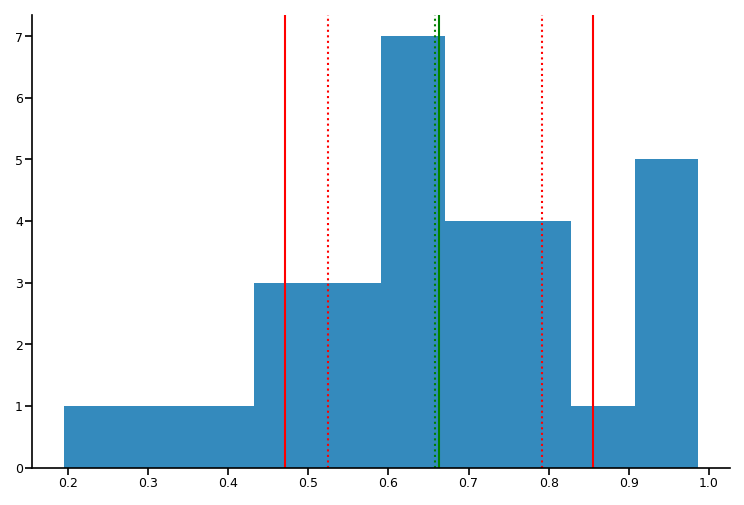

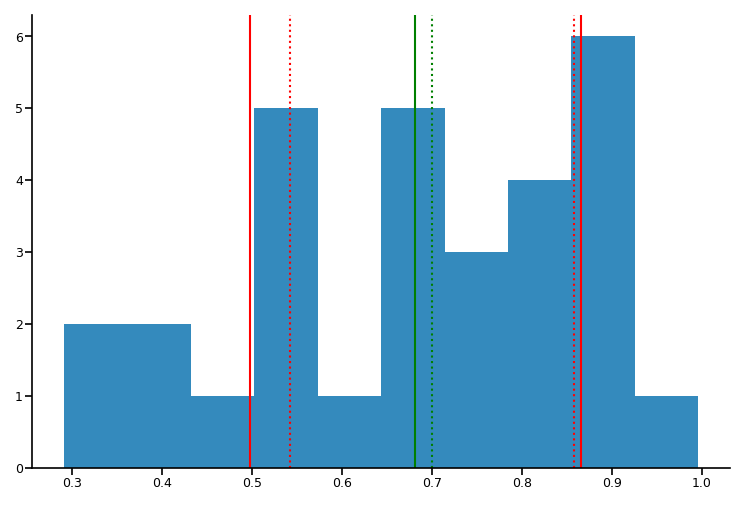

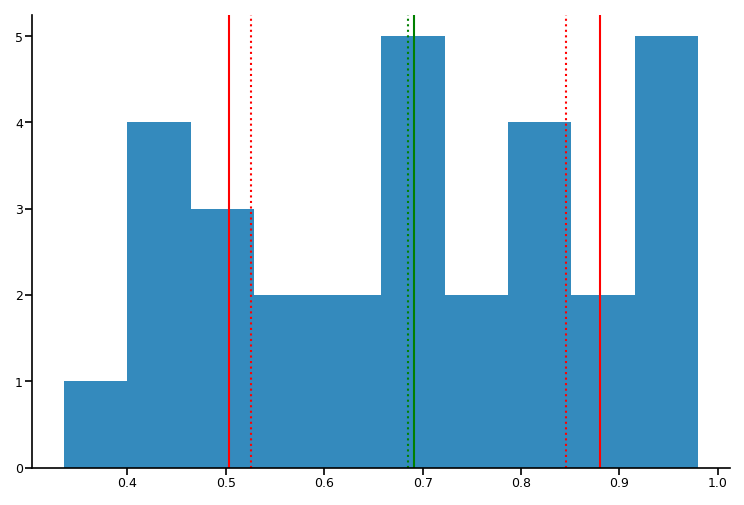

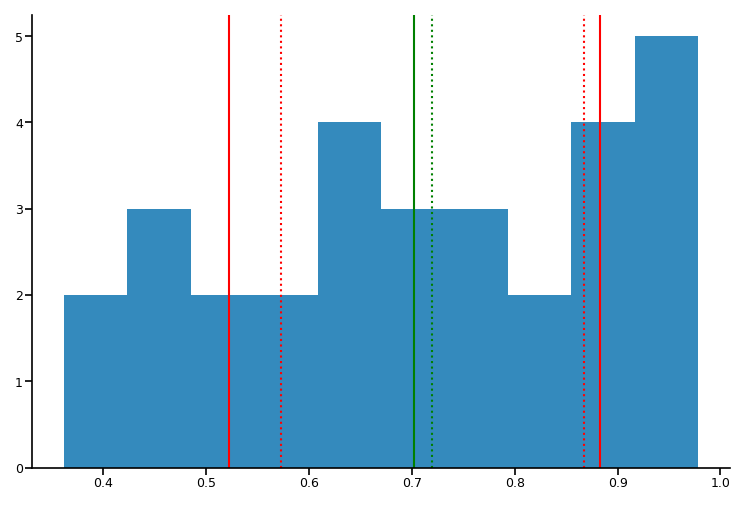

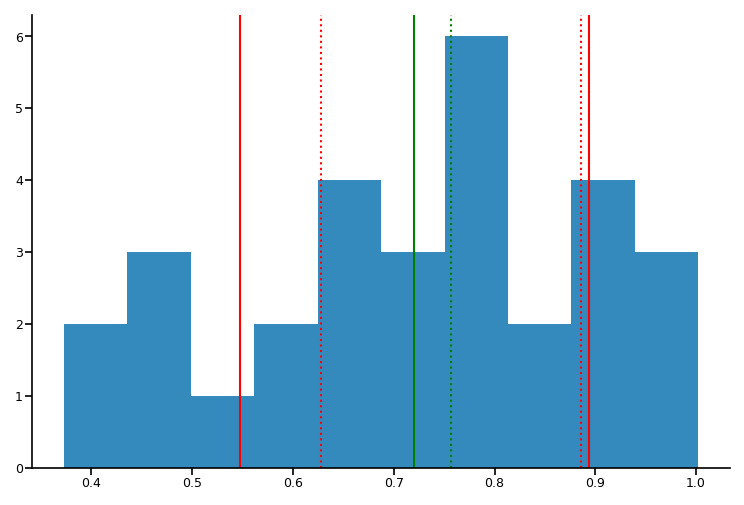

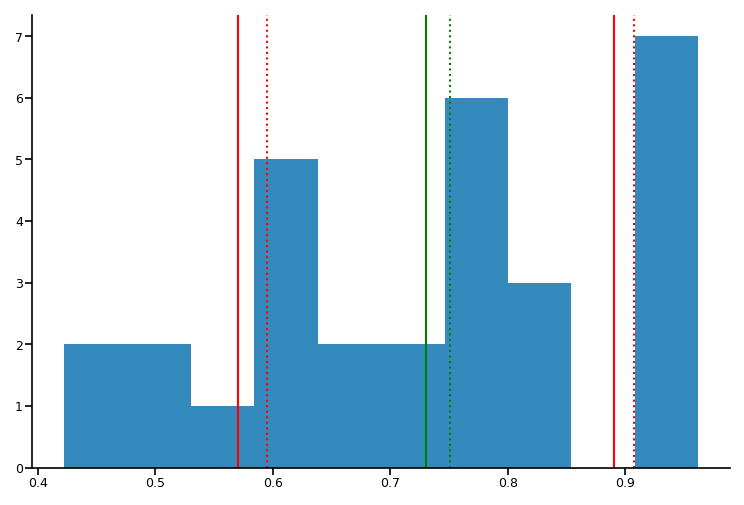

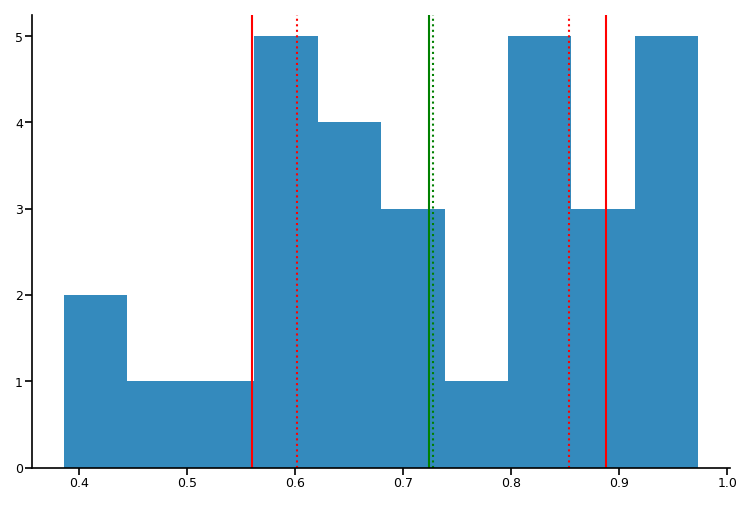

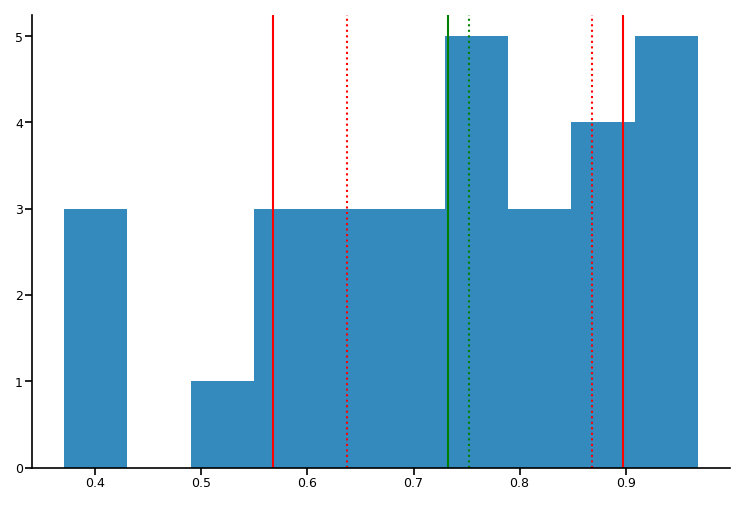

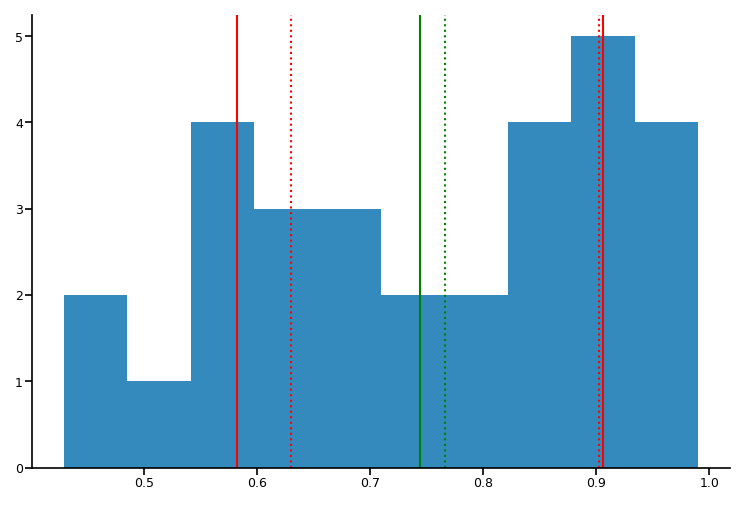

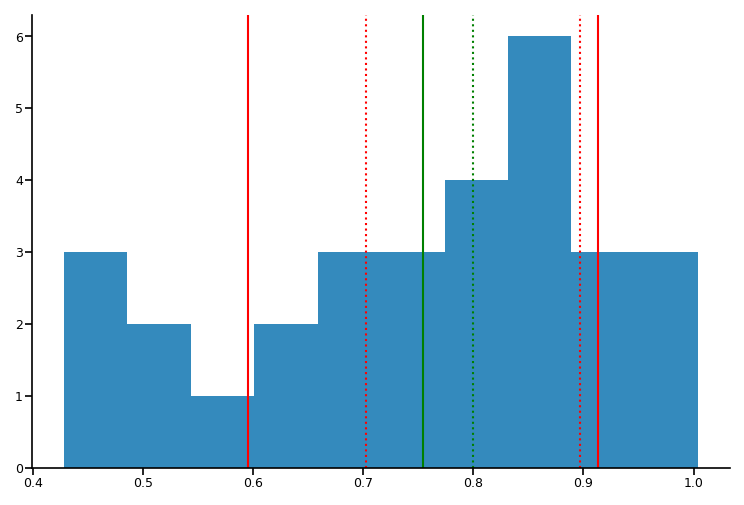

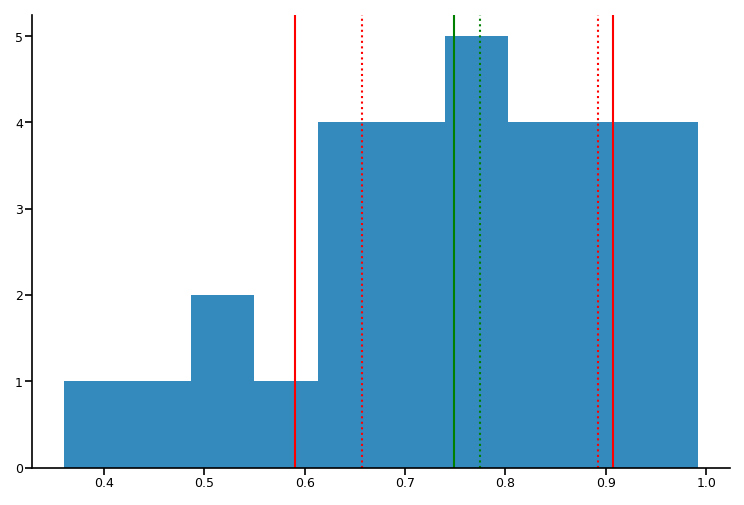

In [20]:
prune_type_id = 1

for i in range(pruning_errors.shape[-1]):
    fig,ax = plt.subplots()
    ax.hist(pruning_errors[:,prune_type_id,i])
    m = np.mean(pruning_errors,axis=0)[prune_type_id,i]
    s = np.std(pruning_errors,axis=0)[prune_type_id,i]
    med = np.median(pruning_errors,axis=0)[prune_type_id,i]
    ma = mad(pruning_errors,axis=0)[prune_type_id,i]
    ax.axvline(m, color='green')
    ax.axvline(m + s, color='red')
    ax.axvline(m - s, color='red')
    
    ax.axvline(med, ls=':', color='green')
    ax.axvline(med + ma, ls=':', color='red')
    ax.axvline(med - ma, ls=':', color='red')
    #ax.set_title(np.mean())

In [21]:
np.min(pruning_errors,axis=0)[1], np.max(pruning_errors,axis=0)[1]

(array([0.04364813, 0.04637214, 0.0476103 , 0.04999544, 0.04763062,
        0.05013399, 0.04808369, 0.05062147, 0.05021971, 0.05526568,
        0.05658924, 0.06787655, 0.06262157, 0.06944057, 0.07411363,
        0.07303567, 0.08522228, 0.08318801, 0.08626933, 0.08950825,
        0.09369469, 0.10140353, 0.11379309, 0.11280093, 0.13916723,
        0.12969705, 0.10772124, 0.12547378, 0.11876303, 0.14318314,
        0.13736656, 0.12574694, 0.18031316, 0.14488228, 0.20066132,
        0.2146098 , 0.1875713 , 0.21898516, 0.25219023, 0.21469623,
        0.24099861, 0.23530114, 0.21373646, 0.16953734, 0.22794227,
        0.1851144 , 0.19267468, 0.27612993, 0.25984687, 0.19527505,
        0.29107854, 0.33558872, 0.36183625, 0.37286094, 0.42241746,
        0.38589084, 0.37062782, 0.42929694, 0.42799598, 0.36016732]),
 array([0.08357389, 0.08465831, 0.08064906, 0.73870081, 0.70524001,
        0.75222945, 0.75762552, 0.69163835, 0.78956759, 0.70289671,
        0.67016619, 0.86810362, 0.82565659, 0.

In [22]:
x_ticks = np.linspace(0, ncells, len(pe_true))
plt.plot(x_ticks, pe_true, label='Full Model')
plt.plot(x_ticks, pe_random, label='Random Pruning')
plt.plot(x_ticks, pe_gcs, label='High GCS Pruning')
plt.plot(x_ticks, pe_random_torus, label='Random Torus Pruning')
#plt.plot(x_ticks, pe_sorted_torus, label='Sorted Torus Pruning')
plt.plot(x_ticks, pe_random_inverse_torus, label='Random Inverse Torus Pruning')
plt.legend()
plt.xlabel('#Pruned Cells')
plt.ylabel('Decoding Error')

plt.savefig("/home/vemundss/Desktop/prune")
plt.savefig(experiment.paths['experiment'] / f'plots/pruning')

NameError: name 'pe_true' is not defined

In [ ]:
# NEXT
# -- DONE -- prune with high GCS
# -- DONE -- prune toroid cells sorted on phase - physics phase transtition?
# legg til error shadings på grafene.
# include adverserial attack?
# -- DONE -- prune inverse of toroid cells. path integration remain? ratemaps still grids? toroid still there?
# select phases based on e.g. right side of box.

# Include random initialised network without pruning to show baseline decoding error